In [1]:
import csv
import matplotlib.pyplot as plt
import json
import os
import random

In [2]:
MULTI_GRAPH=False
SMOOTHENING=False
ONLY_STATS=False
s_factor=0.9
MAX_DEG=5
PATH="./"
PKT_SIZE = 88
fields=["time", "frame_time_rel", "tcp_time_rel", "frame_num", "frame_len", "ip_src", "src_port", "ip_dest", "dest_port", "tcp_len", "seq", "ack"]

In [3]:
class pkt:
    contents=[]
    def __init__(self, fields) -> None:
        self.contents=[]
        for f in fields:
            self.contents.append(f)
    def get(self, field):
        return self.contents[fields.index(field)]

In [4]:
def process_flows(cc, dir):
    name = dir+cc+"-tcp.csv"
    with open(name) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        '''
        Flow tracking:
        o Identify all packets that are either sourced from or headed to 100.64.0.2
        o Group different flows by client's port
        '''
        flows={}
        data_sent=0
        # ACK and RTX measurement
        ooa = set()
        rp = set()
        ooaCount=0
        rpCount=0
        backAck=0
        # Keep track of bif per flow
        bif_map = {} # key: flow, value: list of [bif, timestamp] values
        for row in csv_reader:
            reTx=0
            ooAck=0
            dupAck=0
            retPacket=0
            packet=pkt(row)
            ackPkt=False
            validPkt=False
            if line_count==0:
                # reject the header
                line_count+=1
                continue
            if data_sent == 0 :
                if "100.64.0." in packet.get("ip_src"):
                    num = int(packet.get("ip_src")[-1])
                    if num%2==0:
                        data_sent=1
                        host_port=packet.get("ip_src")
                if "100.64.0." in packet.get("ip_dest"):
                    num = int(packet.get("ip_dest")[-1])
                    if num%2==0:
                        data_sent=1
                        host_port=packet.get("ip_dest")
                if data_sent == 0:
                    continue
            if packet.get("ip_src")==host_port and packet.get("frame_time_rel")!='' and packet.get("ack")!='':
                # we care about this ACK packet
                validPkt=True
                ackPkt=True
                port=packet.get("src_port")
                if port not in flows:
                    flows[port]={"OOA":[],"DA":[],"max_seq":0,"loss_bif":0,"max_ack":int(packet.get("ack")),"serverip":packet.get("ip_dest"), "serverport":packet.get("dest_port"), "act_times":[],"times":[], "windows":[], "cwnd":[], "bif":0, "last_ack":0, "last_seq":0, "pif":0, "drop":[], "next":0, "retrans":[]}
                else:
                    # check for Out of Order Ack (OOA)
                    if int(packet.get("ack")) <= int(flows[port]["max_ack"]):
                        if int(packet.get("ack")) == backAck :
                            dupAck = True
                            flows[port]["DA"].append(float(packet.get("frame_time_rel")))
                        else:
                            ooAck = True
                            flows[port]["OOA"].append(float(packet.get("frame_time_rel")))
                        backAck = int(packet.get("ack")) 
                    # update max_ack
                    flows[port]["max_ack"] = max(flows[port]["max_ack"], int(packet.get("ack")))
                    if int(packet.get("seq")) < flows[port]["max_ack"]:
                        reTx += int(packet.get("tcp_len"))

#                      flows[port]["times"].append(float(packet.get("frame_time_rel")) )

                  
            elif packet.get("ip_dest")==host_port and packet.get("frame_time_rel")!='' and packet.get("seq")!='':

               #we care about this Data packet

                validPkt=True

                port=packet.get("dest_port")

                if port not in flows:

                    flows[port]={"OOA":[],"DA":[],"max_seq":int(packet.get("seq")),"loss_bif":0,"max_ack":0,"serverip":packet.get("ip_src"), "serverport":packet.get("src_port"),"act_times":[], "times":[], "windows":[], "cwnd":[], "bif":0, "last_ack":0, "last_seq":0, "pif":0, "drop":[], "next":0, "retrans":[]}

              

                else:

                    flows[port]["max_seq"] = max(flows[port]["max_seq"], int(packet.get("seq")))

              

                if int(packet.get("seq")) < flows[port]["max_seq"] :

                    retPacket = True

                    flows[port]["retrans"].append(flows[port]["times"][-1])

                   

            if validPkt==True:

                bif = 0

                normal_est_bif = int(flows[port]["max_seq"]) - int(flows[port]["max_ack"]) + PKT_SIZE#+ reTx

                loss_est_bif = flows[port]["loss_bif"]

                if ackPkt and dupAck and len(flows[port]["windows"]) > 10:

                    if dupAck:

                        # if we have received a duplicate ack then we need to reduce the bytes in flight by packet size

                        # we also increase max ack to correct for the consolidated ack being sent later

                        loss_est_bif = int(flows[port]["windows"][-1]) - PKT_SIZE

                        flows[port]["max_ack"] += PKT_SIZE

                      

                        bif = min( normal_est_bif, loss_est_bif)

                      

                elif ackPkt :

                    loss_est_bif = normal_est_bif

                    bif = normal_est_bif   

                    if ooAck :

                        ooaCount+=1

                        ooa.add(int(packet.get("ack")))

 

                else :

                    bif = normal_est_bif
                    if retPacket==True:
                        rpCount+=1
                        rp.add(int(packet.get("seq")))
                flows[port]["loss_bif"] = loss_est_bif
                flows[port]["windows"].append(int(bif))
                flows[port]["times"].append(float(packet.get("frame_time_rel")))
                if port not in bif_map:
                    bif_map[port] = []
                bif_map[port].append([bif, float(packet.get("frame_time_rel"))])
    return bif_map   

opening tracecandidates-measurements-wget-50-200/thepiratebay-tcp.csv...
opening tracecandidates-measurements-wget-50-200/tidal-tcp.csv...
opening tracecandidates-measurements-wget-50-200/akamai-hulu-tcp.csv...
opening tracecandidates-measurements-wget-50-200/tmall-tcp.csv...
opening tracecandidates-measurements-wget-50-200/spotify-tcp.csv...
opening tracecandidates-measurements-wget-50-200/amazon-tcp.csv...
opening tracecandidates-measurements-wget-50-200/dropbox-tcp.csv...
opening tracecandidates-measurements-wget-50-200/zhihu-tcp.csv...
opening tracecandidates-measurements-wget-50-200/youtube-tcp.csv...
opening tracecandidates-measurements-wget-50-200/discord-tcp.csv...
opening tracecandidates-measurements-wget-50-200/reddit-tcp.csv...
opening tracecandidates-measurements-wget-50-200/applemusic-tcp.csv...
opening tracecandidates-measurements-wget-50-200/twitter-tcp.csv...
opening tracecandidates-measurements-wget-50-200/aliexpress-tcp.csv...
opening tracecandidates-measurements-wget

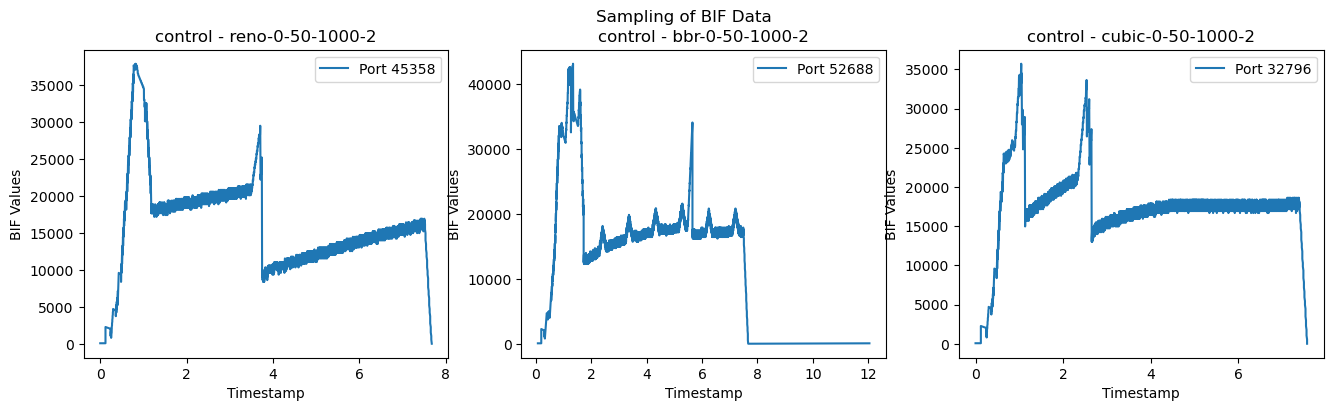

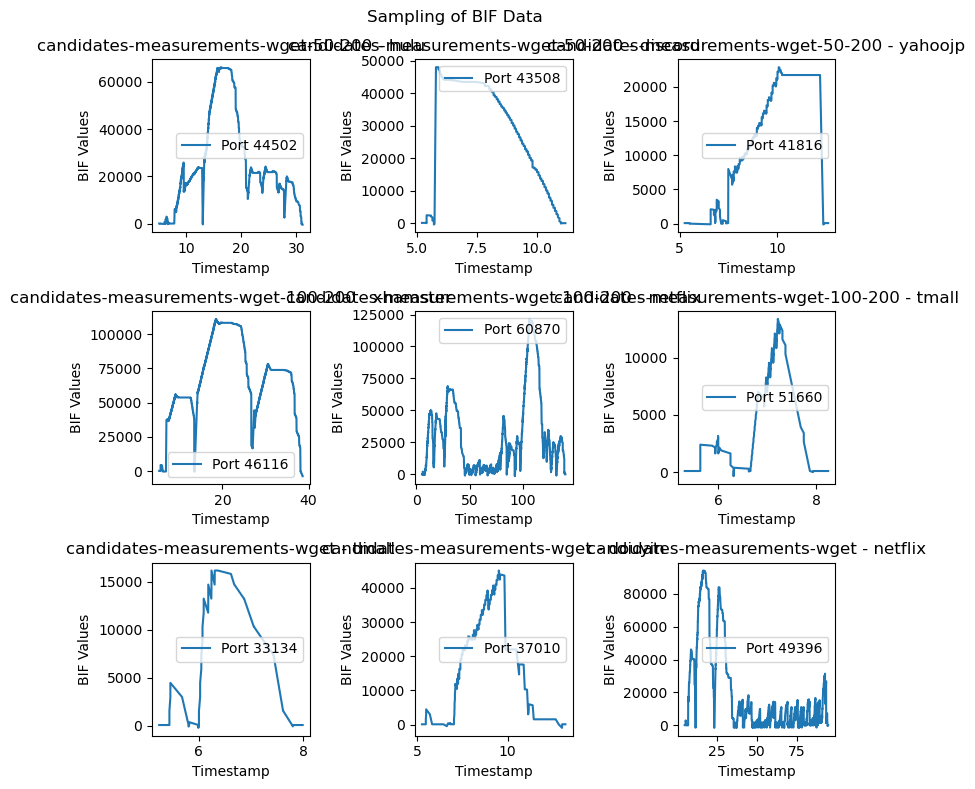

In [5]:
if __name__ == "__main__":
    data_dirs = ["./candidates-measurements-wget-50-200", "./candidates-measurements-wget-100-200", "./candidates-measurements-wget", "./measurements/control"]
    outfile = "bif_data.json"

    # Goal is to generate a JSON file in the format:
    # {
    #     "candidate-measurements-wget-50-200": {
    #        "youtube": {
    #            "123456": [[bif1, timestamp1], [bif2, timestamp2], [bif3, timestamp3]],
    #            "123457": [[bif1, timestamp1], [bif2, timestamp2], [bif3, timestamp3]],
    #            ...
    #        },

 

    #        "disneyplus": {

    #            "123456": [[bif1, timestamp1], [bif2, timestamp2], [bif3, timestamp3]],

    #            ...

    #        },

    #        ...

    #     }

    # }

 

    # Where 123456, etc. are port numbers and bif1, bif2, etc. are the BIF values for that flow

 

    output_data = {}

 

    for data_dir in data_dirs:

        files = [f for f in os.listdir(data_dir) if f.endswith("-tcp.csv") and not f.startswith("-")]

 

        formatted_data_dir = data_dir.split("/")[-1]

 

        output_data[formatted_data_dir] = {}

 

        for f in files:

 

            # File name can have multiple parts separated by "-", so take everything except the last part

            algo_cc = f.split("-")[:-1]

            # Recombine the parts

            algo_cc = "-".join(algo_cc)

            # Get the data for all the flows

            print("opening trace" + formatted_data_dir + "/" + f + "...")

            bifs = process_flows(algo_cc, data_dir + "/")

 

            # Bifs will look like:

 

            # {

            #     "123456": [[bif1, timestamp1], [bif2, timestamp2], [bif3, timestamp3]],

            #     "123457": [[bif1, timestamp1], [bif2, timestamp2], [bif3, timestamp3]],

            #     ...

            # }

 

            output_data[formatted_data_dir][algo_cc] = bifs

 

    with open(outfile, "w") as f:

        json.dump(output_data, f)

 

    print("Data written to " + outfile)

 

    # Sample plot

    if True:

 

        # Sample plot for the last data directory

        # Here there should just be three flows, which are the control flows

 

        fig, axs = plt.subplots(1, 3, figsize=(16, 4))

        fig.suptitle("Sampling of BIF Data")

 

        dir_key = data_dirs[-1].split("/")[-1]

 

        if dir_key in output_data:

            websites = random.sample(list(output_data[dir_key].keys()), k=min(3, len(output_data[dir_key])))

            for j, website in enumerate(websites):

                if website in output_data[dir_key]:

                    flows = output_data[dir_key][website]

                    ax = axs[j]
                    # Plot each flow for the selected website
                    for key, value in flows.items():
                        bif_values = [x[0] for x in value]
                        timestamps = [x[1] for x in value]
                        ax.plot(timestamps, bif_values, label=f"Port {key}")
                    ax.set_title(f"{dir_key} - {website}")
                    ax.set_xlabel("Timestamp")
                    ax.set_ylabel("BIF Values")
                    ax.legend()
        plt.show()
        fig, axs = plt.subplots(3, 3, figsize=(8, 8))
        fig.suptitle("Sampling of BIF Data")
        for i, data_dir in enumerate(data_dirs[:-1]):
            dir_key = data_dir.split("/")[-1]
            if dir_key in output_data:
                websites = random.sample(list(output_data[dir_key].keys()), k=min(3, len(output_data[dir_key])))
                for j, website in enumerate(websites):
                    if website in output_data[dir_key]:
                        flows = output_data[dir_key][website]
                        ax = axs[i, j]
                        # Plot each flow for the selected website
                        for key, value in flows.items():
                            bif_values = [x[0] for x in value]
                            timestamps = [x[1] for x in value]
                            ax.plot(timestamps, bif_values, label=f"Port {key}")

                      

                        ax.set_title(f"{dir_key} - {website}")

                        ax.set_xlabel("Timestamp")

                        ax.set_ylabel("BIF Values")

                        ax.legend()

 

        plt.tight_layout()

        plt.show()